In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from IPython import display

from tensorflow.keras.layers import Input, Activation, Dense, Flatten, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model

from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from datetime import datetime
from tensorflow.keras import layers
from collections import deque
from tqdm import trange, notebook
import random
import time



In [6]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [7]:
class Agent:

    def __init__(self, env):
        self.env = env
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.n

        self._build_network()
        #self.create_model()
        
    def _build_network(self):
        inputs = Input(shape=(self.input_dim, ))  #X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)
        hidden1 = Dense(10, )(inputs)
        hidden2 = Dense(10, activation='relu')(hidden1)
        output = Dense(self.output_dim, )(hidden2) # W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))
        self. model = Model(inputs=inputs, outputs=output)
        adam = tf.keras.optimizers.Adam(lr=0.1)
        self.model.compile(optimizer=adam, loss='mse')
        self.model.summary()
 
    def create_model(self, hidden_dims=[64, 64]):
        X = Input(shape=(self.input_dim, ))

        net = RepeatVector(self.input_dim)(X)
        net = Reshape([self.input_dim, self.input_dim, 1])(net)

        for h_dim in hidden_dims:
            net = Conv2D(h_dim, [3, 3], padding='SAME')(net)
            net = Activation('relu')(net)

        net = Flatten()(net)
        net = Dense(self.output_dim)(net)

        #self.model = Model(inputs=X, outputs=net)
        #self.model.compile('rmsprop', 'mse')

    def act(self, X, eps):
        if np.random.rand() < eps:
            return self.env.action_space.sample()
        
        X = X.reshape(-1, self.input_dim)
        Q = self.model.predict_on_batch(X)
        return np.argmax(Q, 1)[0]
        
    def train(self, X_batch, y_batch):
        return self.model.train_on_batch(X_batch, y_batch)
        
    def predict(self, X_batch):
        #print(x.shape)
        return self.model.predict_on_batch(X_batch)
        
    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        return self.model.set_weights(weights)

In [8]:
def create_batch(agent, agent_T, memory, batch_size, discount_rate):
    sample = random.sample(memory, batch_size)
    sample = np.asarray(sample)
    
    s = sample[:, 0]
    a = sample[:, 1].astype(np.int32)
    r = sample[:, 2]
    s2 = sample[:, 3]
    d = sample[:, 4].astype(np.int32)
    
    X_batch = np.vstack(s)
    y_batch = agent.predict(X_batch)
    
    y_batch[np.arange(batch_size), a] = r + discount_rate * np.max(agent_T.predict(np.vstack(s2)), 1) * (1 - d)
    
    return X_batch, y_batch

def print_info(episode, reward, eps):
    msg = f"[Episode {episode:>5}] Reward: {reward:>5} EPS: {eps:>3.2f}"
    print(msg)
    


def test_play(agent, env):
    s = env.reset()
    done = False
    episode_reward = 0
    reward_sum = 0
    while not done:
        show_state(env)
        a = agent.act(s, 0)
        s2, r, done, info = env.step(a)
        episode_reward += r
        print(f"Episode Reward: {episode_reward}")
        return episode_reward
    
def test_play_loop(agent, env):
    s = env.reset()
    done = False
    episode_reward = 0
    reward_sum = 0
    while True:
        show_state(env)
        a = agent.act(s, 0)
        s, r, done, info = env.step(a)
        episode_reward += r
        if done:
            print(f"Episode Reward: {episode_reward}")
            s = env.reset()
            time.sleep(2)


KeyboardInterrupt: 

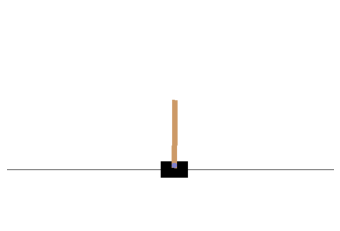

In [9]:
def main():
    n_episode = 1600
    discount_rate = 0.95
    n_MEMORY = 50000
    batch_size = 32
    eps = 1.0
    min_eps = 0.01
    
    env = gym.make('CartPole-v0')
    
    agent = Agent(env)
    agent_T = Agent(env)
    
    memory = deque()
    last_200_rewards = deque()


    for episode in notebook.tqdm(range(n_episode)):
        #e = 1. / ((episode / 10) + 1)
        done = False
        s = env.reset()
        eps = max(min_eps, eps - 1 / n_episode)
        #eps = max(min_eps, eps - 3 / n_episode)
        episode_reward = 0
            
        while not done:
                
            a = agent.act(s, eps)
            s2, r, done, info = env.step(a)
            episode_reward += r
                
            if done and episode_reward < 200: 
                r = -100
            
            memory.append([s, a, r, s2, done])
                
            if len(memory) > n_MEMORY:
                memory.popleft()
                    
            if len(memory) > batch_size and last_200_rewards[-1] < 200:
                X_batch, y_batch = create_batch(agent, agent_T, memory, batch_size, discount_rate)
                agent.train(X_batch, y_batch)
                
            if episode % 5 == 0:
                weights = agent.get_weights()
                agent_T.set_weights(weights)

            s = s2
                
        print_info(episode, episode_reward, eps)
            
        last_200_rewards.append(episode_reward)
            
        if len(last_200_rewards) > 200:
            last_200_rewards.popleft()
                
            avg_score = np.mean(last_200_rewards)
                
            if avg_score > 195:
                print(f"Game Cleared in {episode}: Avg Rewards: {avg_score}")
                break;
                
    test_play_loop(agent, env)
    env.close()

if __name__ == "__main__":
    main()
